# Conditional Masked Autoregressive Flow
Here we go through a simple example of recovering a posterior with SBI. For this, we will use an analytic model, for which we can then compare the result of a fitted and analytic likelihood (and posterior).
 
## Model
The simple model has two parameteres, $\mu_0$ and $\sigma_0$. Prior distributions are defined as:
$$P(\mu_0) = \frac{1}{2\pi} \exp \left(-\frac{1}{2} \mu_0^2\right)$$
$$P(\log_{10} \sigma_0) = \begin{cases} 1 & \text{for} -1/2 < \log_{10} \sigma_0 < 1/2 \\ 0 & \text{otherwise}\end{cases}$$

We'll work in a 5D data space, where the analytic likelihood is given by:
$$P(\boldsymbol{d} | \mu_0, \sigma_0) = \frac{1}{(2\pi)^{5/2} |\Sigma|^{1/2}} \exp\left(-\frac{1}{2} (\boldsymbol{d} - \boldsymbol{\mu})^T \Sigma^{-1} (\boldsymbol{d} - \boldsymbol{\mu})\right) \, ,$$
where $$\boldsymbol{\mu} = (1^2, 2^2, 3^2, 4^2, 5^2) \cdot \mu_0 \, ,$$
$$\Sigma = 
\begin{pmatrix}
1^2 & 0 & 0 & 0 & 0\\
0 & 2^2 & 0 & 0 & 0\\
0 & 0 & 3^2 & 0 & 0\\
0 & 0 & 0 & 4^2 & 0\\
0 & 0 & 0 & 0 & 5^2
\end{pmatrix} \cdot \sigma^2_0 \, .$$

## Fitting the likelihood
To fit the likelihood we create 100 000 data samples of the likelihood function, for $\mu_0$ and $\sigma_0$ pulled from the prior. In this way, the training set follows the prior distribution. This is not strictly necessary. Because we fit the likelihood, final posterior recovery will be insensitive on how were the training samples constructed. The benefit of using the real prior however, is to allow the network to learn important part of the parameter space.

## Mock measurement
With this at hand, we sample 10 points from the analytic likelihood as our mock measurement, for fixed $\mu_0 = 1$, $\sigma_0 = 1$ and try to recover posterior using the fitted likelihood. The final result is then compared with the posterior recovered from the analytic likelihood.



In [1]:
# setup
%matplotlib inline
%load_ext autoreload
%autoreload 2

from functools import partial
import logging
import corner
import ultranest
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

from py21cmlikelihoods import ConditionalMaskedAutoregressiveFlow
from py21cmlikelihoods.utils import prepare_dataset

tfd = tfp.distributions
tfb = tfp.bijectors

ultranest_logger = logging.getLogger("ultranest")
ultranest_logger.addHandler(logging.NullHandler())
ultranest_logger.setLevel(logging.INFO)

2023-11-20 14:39:55.432549: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# constructing the likelihood
NDE = ConditionalMaskedAutoregressiveFlow(
    cond_n_dim = 2, 
    n_dim = 5, 
    hidden_units_dim = 50,
    n_MADEs = 3,
    optimizer = tf.optimizers.Adam(1e-3), 
    kernel_initializer=tf.keras.initializers.RandomNormal,
    kernel_initializer_kwargs = {"mean":0.0, "stddev": 1e-4, "seed":None},
    # kernel_initializer = "glorot_uniform",
    # kernel_initializer_kwargs = {},
    bias_initializer = "zeros",
    bias_initializer_kwargs={},
    last_layer_bias_initializer = "zeros",
    kernel_regularizer = tf.keras.regularizers.L1L2(l1=1e-6, l2=1e-6),
    bias_regularizer = tf.keras.regularizers.L1L2(l1=1e-6, l2=1e-6),
)

/usr/local/Caskroom/miniconda/base/envs/SBI-tutorial/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [3]:
# constructing the training set
mu_0 = np.random.normal(0.0, 1.0, size = 100000)
sigma_0 = np.random.uniform(0.5, 5.0, size = 100000)
params = np.stack([mu_0, sigma_0], axis = -1)
data = np.array([np.random.multivariate_normal(np.arange(1, 6)**2 * m, np.diag(np.arange(1, 6)**2 * s**2)) for m, s in params])

training_set = prepare_dataset(NDE, data_samples=data, param_samples=params, batch_size=100)

In [4]:
# training the likelihood
NDE.train(
    epochs = 5,
    dataset = training_set,
    save = False,
    save_history = False,
    verbose = 1,
)

Epoch 1/5
1000/1000 [==============================] - 20s 8ms/step - loss: 34.6038
Epoch 2/5
1000/1000 [==============================] - 7s 7ms/step - loss: 17.0977
Epoch 3/5
1000/1000 [==============================] - 8s 7ms/step - loss: 16.4237
Epoch 4/5
1000/1000 [==============================] - 8s 7ms/step - loss: 16.2984
Epoch 5/5
1000/1000 [==============================] - 7s 6ms/step - loss: 16.2763


[ 1.9554203  8.043811  17.961233  32.26961   50.38868  ] [1.0669659 2.5065706 3.3881373 5.8314433 6.555599 ]
[ 1.99827949  7.99328592 18.01797139 32.00392586 49.99395868] [1.00176853 1.99998214 2.99013865 4.00130059 4.99381725]


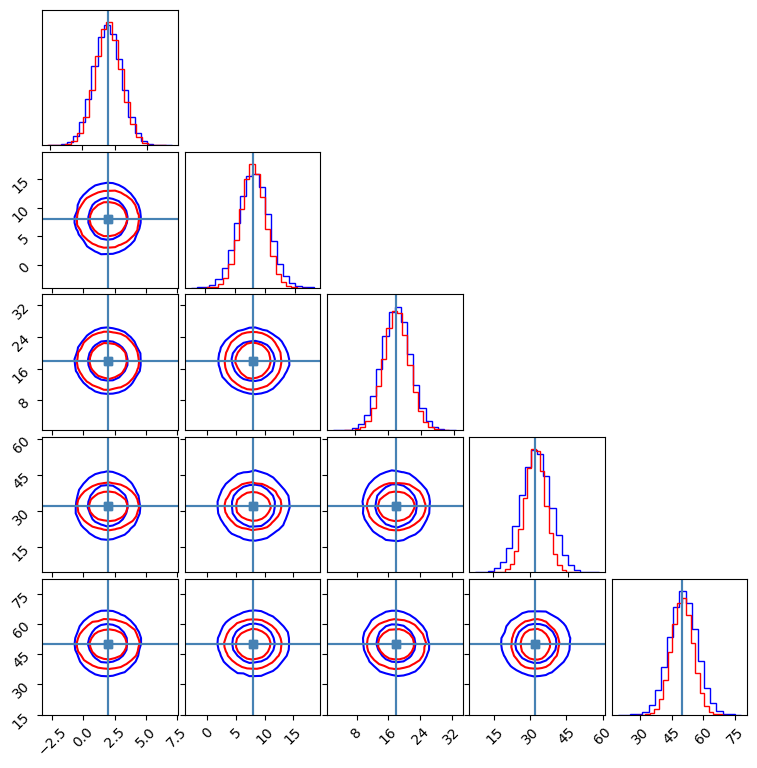

In [5]:
# testing the likelihood shape for mu_0 = 2, sigma_0 = 1
NDE_sample = NDE.sample(100000, conditional = tf.constant([2.0, 1.0])).numpy()
analytic_sample = np.random.multivariate_normal(np.arange(1, 6)**2 * 2, np.diag(np.arange(1, 6)**2), 100000)

fig = plt.figure(figsize = (8, 8))
corner.corner(
    NDE_sample, 
    fig = fig, 
    color = "blue", 
    truths = np.arange(1, 6)**2 * 2, 
    levels = (0.68, 0.95), 
    plot_contour=True,
    plot_density=False,
    plot_datapoints=False,
)
corner.corner(
    analytic_sample, 
    fig = fig, 
    color = "red", 
    truths = np.arange(1, 6)**2 * 2, 
    levels = (0.68, 0.95), 
    plot_contour=True,
    plot_density=False,
    plot_datapoints=False,
)
print(NDE_sample.mean(axis = 0), NDE_sample.std(axis = 0))
print(analytic_sample.mean(axis = 0), analytic_sample.std(axis = 0))

# Recovering posterior
To recover posterior we use fitted NDE likelihood and analytic likelihood, together with prior specified at the beginning. For sampling, we use `ultranest` nested sampler.

As previously mentioned, for the mock measurement we use 10 i.i.d. samples for $\mu_0 = 1$ and $\sigma_0 = 1$. The hope is that final posterior shifts towards those values.

In [6]:
mock_measurement = np.random.multivariate_normal(np.arange(1, 6)**2, np.diag(np.arange(1, 6)**2), 10)

In [7]:
def log_gauss(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma) - 0.5 * (x - mu)**2 / sigma**2 

def analytic_log_likelihood(d, mu_0, sigma_0):
    mu = (np.arange(1, 6)**2).reshape(1, -1) * mu_0.reshape(-1, 1)
    cov = (np.arange(1, 6)**2).reshape(1, -1) * sigma_0.reshape(-1, 1)**2
    c = -2.5 * np.log(2 * np.pi) - 0.5 * np.log(np.prod(cov, axis = -1))
    l = -0.5 * np.sum((d - mu)**2 / cov, axis = -1)
    return c + l

In [10]:
def ultranest_NDE_posterior(p):
    likelihood = np.sum(np.array([NDE.log_prob(mock, p).numpy() for mock in mock_measurement]), axis = 0)
    prior = log_gauss(0.0, p[:, 0], 1.0)
    return prior + likelihood

def ultranest_analytic_posterior(p):
    likelihood = np.sum(np.array([analytic_log_likelihood(mock, p[:, 0], p[:, 1]) for mock in mock_measurement]), axis = 0)
    prior = log_gauss(0.0, p[:, 0], 1.0)
    return prior + likelihood

def transformation(p):
    x = np.zeros(p.shape, dtype = p.dtype)
    x[:, 0] = -5 + 10 * p[:, 0]
    x[:, 1] = 0.5 + 4.5 * p[:, 1]
    return x

In [ ]:
sampler_NDE = ultranest.ReactiveNestedSampler(
    ["mu_0", "sigma_0"], 
    loglike = ultranest_NDE_posterior, 
    transform = transformation,
    vectorized = True,
    draw_multiple = True,
    ndraw_min = 1000,
    ndraw_max = 100000,
)
result_NDE = sampler_NDE.run(
    min_num_live_points = 1000,
    min_ess = 1000,
)
sampler_NDE.print_results()

In [ ]:
sampler_analytic = ultranest.ReactiveNestedSampler(
    ["mu_0", "sigma_0"], 
    loglike = ultranest_analytic_posterior, 
    transform = transformation,
    vectorized = True,
    draw_multiple = True,
    ndraw_min = 1000,
    ndraw_max = 100000,
)
result_analytic = sampler_analytic.run(
    min_num_live_points = 1000,
    min_ess = 1000,
)
sampler_analytic.print_results()

In [ ]:
def cornerplot(results, fig = None, color = None):
    data = np.array(results['weighted_samples']['points'])
    weights = np.array(results['weighted_samples']['weights'])
    print(data.shape, weights.shape)
    cumsumweights = np.cumsum(weights)

    mask = cumsumweights > 1e-4

    fig = corner.corner(
    data[mask, :],
    weights = weights[mask], 
    fig = fig, 
    color = color, 
    truths = [1.0, 1.0], 
    levels = (0.68, 0.95), 
    plot_contour=True,
    plot_density=False,
    plot_datapoints=False,
    labels = ["$\mu_0$", "$\sigma_0$"]
)
    return fig

In [ ]:
fig = plt.figure(figsize = (5, 5))
fig = cornerplot(result_NDE, fig, "blue")
fig = cornerplot(result_analytic, fig, "red")